# Model of the Risk of Traffic Accidents in New York City 

## Springboard Capstone 2 Final Report

### Gene Hopping

January 2020

#Part 2 - convLSTM2D model


In [0]:
#Imports
import pandas as pd
import numpy as np
from numpy import array
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time
import keras
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import plot_model
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from sklearn import metrics
import math
import io
%matplotlib inline

In [95]:
#mount drive to allow access to Google Drive
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Load prepared df from pickle file
all_coords_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/all_coords_df.pkl')

In [97]:
#check it out
all_coords_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293094 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 6 columns):
date         1293094 non-null datetime64[ns]
time         1293094 non-null object
longitude    1293094 non-null float64
latitude     1293094 non-null float64
y            1293094 non-null float64
x            1293094 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 69.1+ MB


In [98]:
all_coords_df.head()

,date,time,longitude,latitude,y,x
datetime,,,,,,
2019-04-16,2019-04-16,0:00,-73.98091,40.737885,586046.344512,4.510160e+06
2019-04-16,2019-04-16,0:00,-73.82261,40.762756,599375.548769,4.513088e+06
2019-04-16,2019-04-16,0:00,-73.82282,40.729404,599407.480337,4.509385e+06
2019-04-16,2019-04-16,0:00,-73.75374,40.665485,605341.759287,4.502370e+06
2019-04-16,2019-04-16,0:00,-73.95117,40.810173,588461.524222,4.518214e+06


In [99]:
#Determining limits of data
ymin = all_coords_df.y.min()
ymax = all_coords_df.y.max()
yrange = (ymax - ymin) / 65 #ground distance of each square in histogam below
xmin = all_coords_df.x.min()
xmax = all_coords_df.x.max()
datemin = all_coords_df.date.min()
datemax = all_coords_df.date.max()
xrange = (xmax - xmin) / 65 #ground distance of each square in histogram below
print(f"The max and min values for y and x are: {ymin}, {ymax}, {xmin} and {xmax}")
print(f'One square represents: x: {xrange}, y: {yrange} meters')
print(f'Date range is from {datemin} to {datemax}')

The max and min values for y and x are: 563160.1705779731, 612885.3478294573, 4483412.260444801 and 4529666.189655863
One square represents: x: 711.5989109394069, y: 765.0027269459097 meters
Date range is from 2012-07-01 00:00:00 to 2019-04-16 00:00:00


Below we will define the size of the histogram by creating two arrays containing the bins defined by taking the extreme values of lat and long and dividing them up evenly. WIll then fill in the accident data for the entire dataset as a test. Next step will want to be able to select the hour period. Note for a 64 cell grid, we need to define 65 grid boundaries.

In [100]:
#setting up 2D array. divide max and min values of coordinates into regular intervals
yedges = np.linspace(ymin, ymax, 65) #330
xedges = np.linspace(xmin, xmax, 65) #330

#generate the histogram using bins defined above
test_hist, yedges, xedges  = np.histogram2d(all_coords_df['y'], all_coords_df['x'], \
                                            bins=(yedges, xedges))
test_hist.shape, type(test_hist)
test_hist

array([[ 34., 186.,  77., ...,   0.,   0.,   0.],
       [117., 183., 221., ...,   0.,   0.,   0.],
       [ 11., 130., 272., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

Let's do some math: 365 days * 24 hours = 8760 2D rastors
I don't think for this project its feasable to do hourly rastors across the whole timeframe. Let's do last 6 months, leaving the last month as the test set?

min date = Dec 16 2018
max date = Apr 16 2019

1. nested loop for day and hour.
2. create a 2D histogram for all day and hour combinations. write to a numpy array
3. test case on 10 days

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


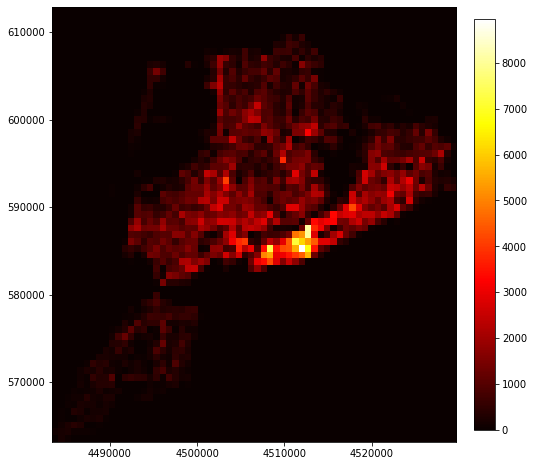

In [103]:
###Testing
#plot the histogram using np.imshow

_ = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(131, title='All accidents as 64 x 64 2D array')
_ = plt.imshow(test_hist, interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/content/drive/My Drive/Colab Notebooks/2D_array_all.png')

***NOTE*** need to work out how to reverse the X-axis. Image is flipped horizontally/

In [86]:
#view the edges
len(all_coords_df.x), yedges

(1293094,
 array([563160.17057797, 563937.12647253, 564714.08236708, 565491.03826164,
        566267.99415619, 567044.95005075, 567821.9059453 , 568598.86183985,
        569375.81773441, 570152.77362896, 570929.72952352, 571706.68541807,
        572483.64131263, 573260.59720718, 574037.55310174, 574814.50899629,
        575591.46489084, 576368.4207854 , 577145.37667995, 577922.33257451,
        578699.28846906, 579476.24436362, 580253.20025817, 581030.15615273,
        581807.11204728, 582584.06794183, 583361.02383639, 584137.97973094,
        584914.9356255 , 585691.89152005, 586468.84741461, 587245.80330916,
        588022.75920372, 588799.71509827, 589576.67099282, 590353.62688738,
        591130.58278193, 591907.53867649, 592684.49457104, 593461.4504656 ,
        594238.40636015, 595015.36225471, 595792.31814926, 596569.27404381,
        597346.22993837, 598123.18583292, 598900.14172748, 599677.09762203,
        600454.05351659, 601231.00941114, 602007.9653057 , 602784.92120025,
  

In [0]:
# write a loop to select date and hour start with last 6 months

list_of_accidents = []
#loop over them
for i in pd.date_range(start='12-02-2018', end='4-16-2019', freq='H'):
    
# generate the individual histograms. use .loc accessor to loop per day >= current day < next day then increment
    test_hist, yedges, xedges  = np.histogram2d(all_coords_df.loc[(all_coords_df.index >= i) & \
                                    (all_coords_df.index < (i + timedelta(hours=1)))].y, \
                                    all_coords_df.loc[(all_coords_df.index >= i) & \
                                    (all_coords_df.index < (i + timedelta(hours=1)))].x, bins=(yedges, xedges))
    list_of_accidents.append(test_hist)
    print(len(list_of_accidents))
    
#convert the list or arrays into a numpy array - the desired format for the Keras model
array_of_accidents = np.array(list_of_accidents)
print('array shape:', array_of_accidents.shape)


In [0]:
#convLSTM2D requires input array to have 4 dimensions
array_of_accidents_reshape = array_of_accidents.reshape(3241,64,64,1)

In [89]:
#out of interest, how many accidents on this day
array_of_accidents[17].sum()

34.0

## Feature Engineering

In [90]:
#how many 2D arrays do we have
len(array_of_accidents)

3241

old index 012345678910

new index XXXXX12345

Will lose arrays 0 to 5 due to the summing of 6 arrays. This means array length will reduce from 3241 to 3236

In [0]:
#We need to take the average of the preceeding 6 arrays
i=0
array_of_frequency = np.zeros(shape=(3236,64,64)) # create the correct number of 0 filled arrays then populate
for i in range(3236):
        array_of_frequency[i] = (array_of_accidents[i] + array_of_accidents[i+1] + array_of_accidents[i+2] + array_of_accidents[i+3] + array_of_accidents[i+4] + array_of_accidents[i+5])/6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


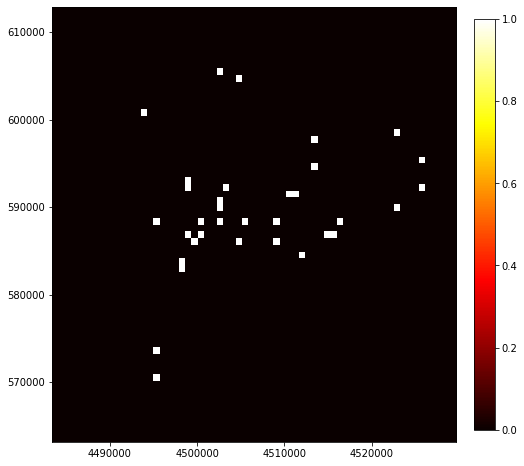

In [105]:
#plot the histogram of just one hour slice of accidents
_ = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(131, title='number of accidents')
_ = plt.imshow(array_of_accidents[17], interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/content/drive/My Drive/Colab Notebooks/2D_array_1h.png')

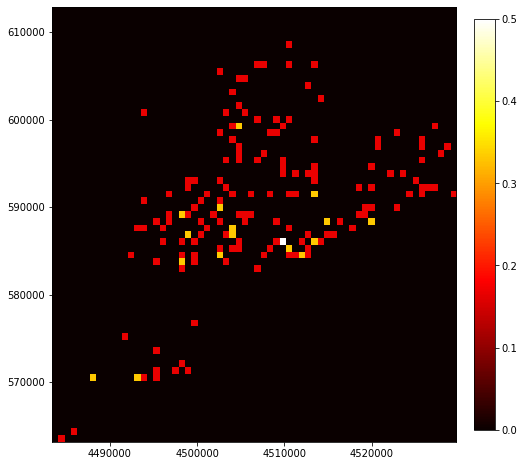

In [106]:
#plot the histogram of just one hour of accident rate, based on average of past 6 days
_ = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(131, title='6 hour accident rate')
_ = plt.imshow(array_of_frequency[12], interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/content/drive/My Drive/Colab Notebooks/2D_array_6h.png')

In [0]:
array_of_frequency_reshape = array_of_frequency.reshape(3236,64,64,1)

We're going to approach this as a classification model. We want to know if there is the risk of an accident at a certain time of the day. Any grid cell that registered a rate will become 1 to indicate there is the risk of an accident in that grid cell at that time. This model will not descriminate between a single accident, or many accidents during that hour.

In [0]:
#Turning this into a classification problem.
#Convert all non-zero entries into 1
binarize = True
if binarize:

  array_of_frequency_reshape[array_of_frequency_reshape > 0] = 1


In [20]:
#what are the dimensions?
print(array_of_frequency.shape, len(array_of_frequency) / 7) #how many time steps
#train, test, validate
# 70   :  20 :  10
#2265:647:324
train_array = array_of_frequency_reshape[:2265]
test_array = array_of_frequency_reshape[2265:-324]
validate_array = array_of_frequency_reshape[-324:]

len(train_array), len(test_array), len(validate_array)

(3236, 64, 64) 462.2857142857143


(2265, 647, 324)

We need to split the arrays so we can send 6 to X and the next to y. We will train the model on the preceeding 6 hours to prdict the 7th. To do this, we will use the Keras function TimeseriesGenerator

In [21]:
#Define a generator to select data using keras TimeseriesGenerator
# length - number of lag observations to use in the input for each sample
# batch_size - 

n_input = 6 # Want to train on 6 to predict 7th
train_generator = TimeseriesGenerator(train_array, train_array, length=n_input, batch_size=1) # 373 sets of 6 x 1 hour matrices - when set to 1, reproduces plot of all accidents
test_generator = TimeseriesGenerator(test_array, test_array, length=n_input, batch_size=1) # 42 sets of 6 x 1 hour matrices
validate_generator = TimeseriesGenerator(validate_array, validate_array, length=n_input, batch_size=1)
generator = TimeseriesGenerator(array_of_accidents, array_of_accidents, length=n_input, batch_size=1)
# number of samples
print('Length of train generator: %d' % len(train_generator))
print('Length of test generator:', len(test_generator))
print('Length of validate generator:', len(validate_generator))
# print each sample
for i in range(len(train_generator)):
    X, y = train_generator[i]
    #print('%s => %s' % (x, y))
print('check shape of arrays:', X.shape, y.shape) #what shape do X and y have 

Length of train generator: 2259
Length of test generator: 641
Length of validate generator: 318
check shape of arrays: (1, 6, 64, 64, 1) (1, 64, 64, 1)


# Model building

In [0]:
#checking to make sure 6 frames assigned to X and 1 to y
X, y = test_generator[27]

In [23]:
X.shape, y.shape

((1, 6, 64, 64, 1), (1, 64, 64, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


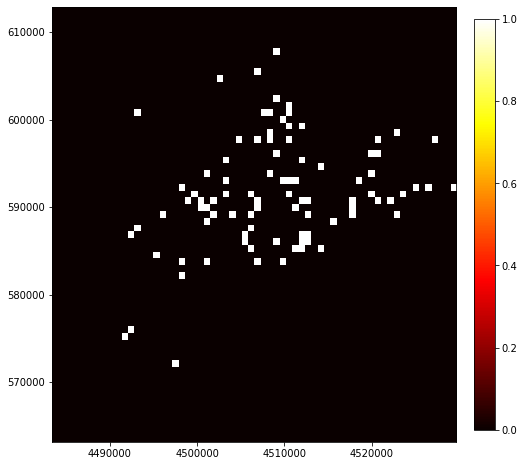

In [108]:
#plot the histogram using np.imshow
_ = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(131, title='imshow: square bins')
_ = plt.imshow(y.reshape(64,64), interpolation='nearest', cmap='hot', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/content/drive/My Drive/Colab Notebooks/2D_array_bin.png')

# Defining the Keras model

In [25]:

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = Sequential()
seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   input_shape=(None, 64, 64, 1),
                   padding='same', activation='relu', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   padding='same',  activation='relu',  return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   padding='same',  activation='relu',  return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(5,5),
                   padding='same',  activation='relu',  return_sequences=False))
seq.add(BatchNormalization())

seq.add(Conv2D(filters=1, kernel_size=(5,5),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0000001), metrics=['binary_accuracy']) #loss='binary_crossentropy', optimizer='adadelta'
seq.summary()














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  819456    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 64, 64, 64)  819456    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 64, 64, 64)  256       
_____________

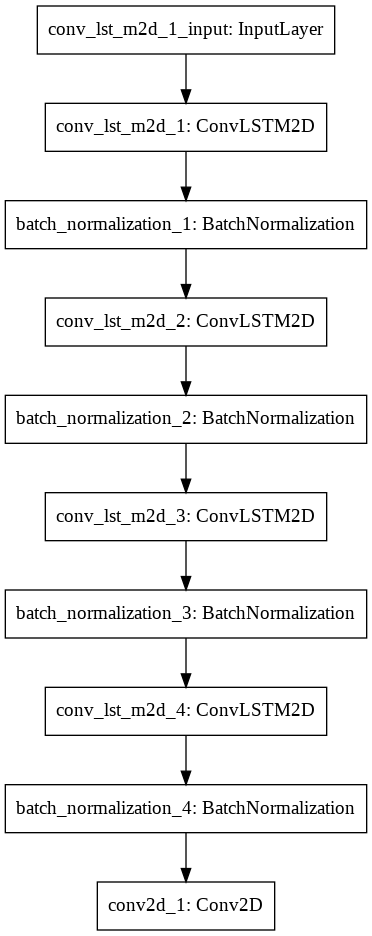

In [26]:
#Create image of the model structure
plot_model(seq, to_file='/content/drive/My Drive/Colab Notebooks/model_paper.png')

# Train the model

In [0]:

early_stopping_monitor = EarlyStopping(patience=2)
run_model = False   
if run_model:
    history_2_bin = seq.fit_generator(train_generator, epochs=50, validation_data=test_generator, callbacks=[early_stopping_monitor]) #including accuracy for classification


In [0]:
save_model = False
if save_model:
    seq.save('/content/drive/My Drive/Colab Notebooks/final_model_bin.h5') #seq4, 2 layers, , dropout, 50 epochs activation='sigmoid' loss='binary_crossentropy' 
    print("Saved model to disk")


In [29]:
load_the_model = True
if load_the_model:
    seq = load_model('/content/drive/My Drive/Colab Notebooks/final_model_bin.h5')
    print('Loaded model from disk')



Loaded model from disk


In [0]:
save_weights = False
if save_weights:
    seq.save_weights('/content/drive/My Drive/Colab Notebooks/final_weights_bin.h5')
    #save history
    hist_df=pd.DataFrame.from_dict(history_2_bin.history)
    hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/final_history_bin.csv')

Let's look at a prediction

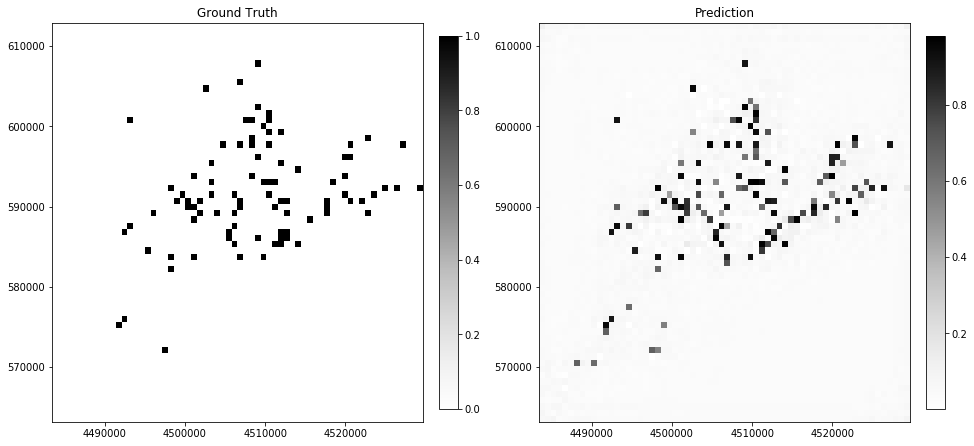

In [109]:
#plot the histogram using np.imshow
_ = plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.title('Ground Truth')
_ = plt.imshow(y.reshape(64,64), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.title('Prediction')
prediction = seq.predict(X) # make a prediction by feeding it 6 frames
#plot the histogram using np.imshow
_ = plt.imshow(prediction.reshape(64,64), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/content/drive/My Drive/Colab Notebooks/prob_output.png')

Note that the output of the model are probabilities

In [32]:
#read in history and check to see that 50 epochs were run
history = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_history_bin.csv')
history.tail()

,Unnamed: 0,val_loss,val_binary_accuracy,loss,binary_accuracy
45,45,0.067440,0.991302,0.071283,0.991016
46,46,0.065774,0.991307,0.069793,0.991026
47,47,0.063595,0.991312,0.068364,0.991038
48,48,0.062976,0.991326,0.066988,0.991047
49,49,0.060914,0.991348,0.065659,0.991057


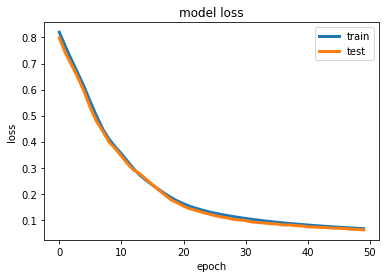

In [33]:
# summarize history for loss
_ = plt.plot(history['loss'], lw=3, )
_ = plt.plot(history['val_loss'], lw=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('/content/drive/My Drive/Colab Notebooks/model_loss2.png')

The output of the model is a probability. We need to stratify the results to either no increase in risk 0, or increase in risk 1. Do this by tranforming any value greater or equal to 0.5 to 1, the rest to 0.

In [0]:
test_df = pd.DataFrame(prediction.reshape(64,64))

In [0]:
#Stratify the probabilities 
binary_test_df = test_df.copy()
binary_test_df[binary_test_df < 0.5] = 0 # any probability less than 0.5 becomes 0
binary_test_df[binary_test_df >= 0.5] = 1 # any probability greater than or equal to 0.5 becomes 1


Now only plot prediction values that have an accident rate greater than 0.5 and compare to ground truth

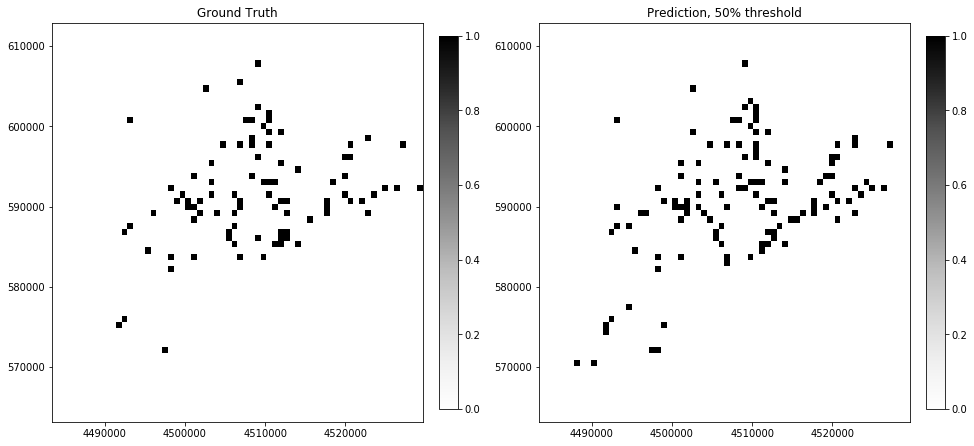

In [111]:
#plot the histogram using np.imshow
_ = plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.title('Ground Truth')
_ = plt.imshow(y.reshape(64,64), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.title('Prediction, 50% threshold')
_ = plt.imshow(np.array(binary_test_df), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/content/drive/My Drive/Colab Notebooks/pred_binary.png')

# Analysis
##Confusion matrix
since prediction and ground truth are both in arrays:






matthews correlation coefficient = 

1.   multiply both together and sum: **True positive**
2.   subtract ground truth from prediction if +1 : **false positive**
3.   if -1 : **false negative**
4.   matrix size - TP -FP-FN : **True negative**





Multiply arrays together. only coincident cells will remain 1, all else will be 0. This gives number of correctly predicted cells. Divide by sum of ground truth array will give percent predicted

In [37]:
pre_pred_array = np.array(binary_test_df) # convert df back to np array
pred_array = pre_pred_array.reshape(1,64,64,1) # reshape back to 4D to match y
score_array = pred_array * y
#score_array = y * np.array(binary_test_df)
y.sum(), np.array(binary_test_df).sum(), score_array.sum(), score_array.sum() / y.sum() * 100


(90.0, 116.0, 82.0, 91.11111111111111)

In [0]:
#create dataframe for ground truth and prediction
ground_truth_df = pd.DataFrame(y.reshape(64,64))
prediction_df = pd.DataFrame(seq.predict_classes(X).reshape(64,64))
product_df = ground_truth_df * prediction_df
difference_df = prediction_df - ground_truth_df

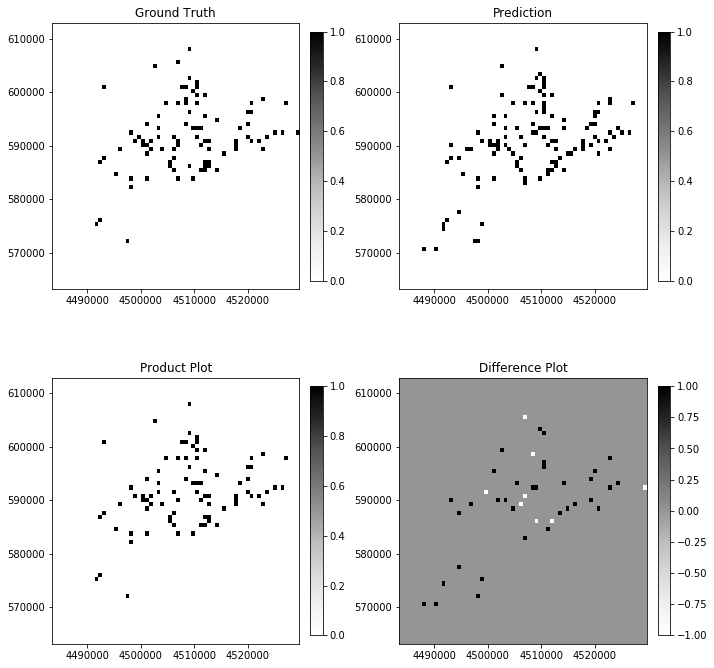

In [39]:
#plot the ground truth, product and difference plots
_ = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Ground Truth')
_ = plt.imshow(pd.DataFrame(y.reshape(64,64)), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(2,2,2)
plt.title('Prediction')
_ = plt.imshow(np.array(prediction_df), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(2,2,3)
plt.title('Product Plot')
_ = plt.imshow(np.array(product_df), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(2,2,4)
plt.title('Difference Plot')
_ = plt.imshow(np.array(difference_df), interpolation='nearest', cmap='Greys', origin='low',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
_ = plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.tight_layout()
plt.savefig('/content/drive/My Drive/Colab Notebooks/confusion_aray_example.png')

In [0]:
# ground truth
ground_truth = int(np.array(ground_truth_df.sum()).sum())
# true positive
true_pos = int(np.array(product_df).sum())
# false positive
false_pos = int((difference_df[difference_df == 1].sum()).sum())
# false negative
false_neg = int(abs((difference_df[difference_df == -1]).sum().sum()))
# true negative
true_neg = int((len(ground_truth_df) * len(ground_truth_df)) - true_pos - false_pos - false_neg)

In [0]:
# Matthew's correlation coefficient a value of 1 is perfect prediction, 0 is same as random chance
MCC = (true_pos * true_neg - false_pos * false_neg) / \
    math.sqrt((true_pos + false_pos)*(true_pos + false_neg)*(true_neg + false_pos)*(true_neg + false_neg))


In [42]:
print(f'Ground truth: {ground_truth}')
print(f'True positives: {true_pos}')
print(f'False positives: {false_pos}')
print(f'False negatives: {false_neg}')
print(f'True negatives: {true_neg}')
print(f'Matthew\'s correlation coefficient: {MCC}')

Ground truth: 90
True positives: 82
False positives: 34
False negatives: 8
True negatives: 3972
Matthew's correlation coefficient: 0.7976511531639582


In [0]:
#define the list of sets we want to use
set_list = [train_generator, test_generator, validate_generator]

In [0]:
#calculate the confusion matrix for the entire sets
calc_confusion = False
if calc_confusion:
    def run_confusion(set_list):
        """ Function to run the confusion matrix with specified sets, such as train, test and validate
        set_list contains the variables corresponding to the generators of interest
        """

    for setlist in set_list:

        df = pd.DataFrame(columns=['ground_truth', 'true_positive', 'false_positive', 'false_negative', 'true_negative'])
        ground_truth_list = []
        true_pos_list = []
        false_pos_list = []
        false_neg_list = []
        true_neg_list = []

        for i in setlist:

            #assign the data to the variables    
            X, y = i

            #create dataframes for ground truth, prediction, the product and difference of the two
            ground_truth_df = pd.DataFrame(y.reshape(64,64))
            prediction_df = pd.DataFrame(seq.predict_classes(X).reshape(64,64))
            product_df = ground_truth_df * prediction_df
            difference_df = prediction_df - ground_truth_df

            # count ground truth
            ground_truth_list.append(int(np.array(ground_truth_df.sum()).sum()))
            # calc true positive
            true_pos_list.append(int(np.array(product_df).sum()))
            # calc false positive
            false_pos_list.append(int((difference_df[difference_df == 1].sum()).sum()))
            # calc false negative
            false_neg_list.append(int(abs((difference_df[difference_df == -1]).sum().sum())))
            # calc true negative
            true_neg_list.append(int((len(ground_truth_df) * len(ground_truth_df)) - \
                int(np.array(product_df).sum()) - \
                int((difference_df[difference_df == 1].sum()).sum()) - \
                int(abs((difference_df[difference_df == -1]).sum().sum()))))

        #read lists into one dataframe    
        df['ground_truth'] = ground_truth_list
        df['true_positive'] = true_pos_list
        df['false_positive'] = false_pos_list
        df['false_negative'] = false_neg_list
        df['true_negative'] = true_neg_list
        
    
        # using apply function to create a new column: Matthew's correlation coefficient
        # MCC = (TP*TN - FP*FN) / sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        df['Matthews_correlation'] = df.apply(lambda row: (row.true_positive * row.true_negative - \
                                            row.false_positive * row.false_negative) / math.sqrt((row.true_positive + \
                                            row.false_positive)*(row.true_positive + row.false_negative)*\
                                            (row.true_negative + row.false_positive)*(row.true_negative + \
                                                                                    row.false_negative)), axis = 1)
        if setlist == train_generator:
            train_confusion_df = df.copy()
        elif setlist == test_generator:
            test_confusion_df = df.copy()
        else:
            validate_confusion_df = df.copy()

In [0]:
# save data
save_confusion_df = False
if save_confusion_df:
    train_confusion_df.to_pickle('/content/drive/My Drive/Colab Notebooks/train_confusion_df.pkl')
    test_confusion_df.to_pickle('/content/drive/My Drive/Colab Notebooks/test_confusion_df.pkl')
    validate_confusion_df.to_pickle('/content/drive/My Drive/Colab Notebooks/validate_confusion_df.pkl')

In [0]:
#read data
read_confusion = True
if read_confusion:
    train_confusion_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/train_confusion_df.pkl')
    test_confusion_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/test_confusion_df.pkl')
    validate_confusion_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/validate_confusion_df.pkl')

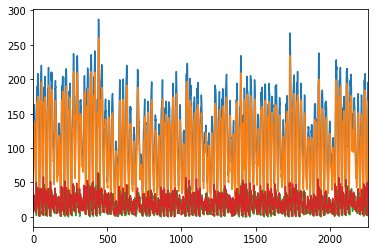

In [47]:
#plot
train_confusion_df.ground_truth.plot()
train_confusion_df.true_positive.plot()
train_confusion_df.false_positive.plot()
train_confusion_df.false_negative.plot()

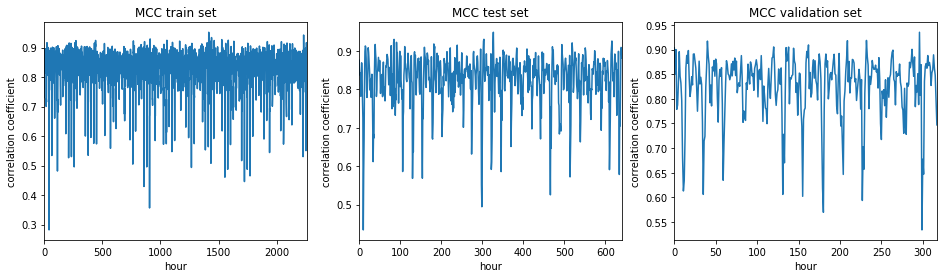

In [48]:
#plot the correlation coefficients
fig = plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
train_confusion_df.Matthews_correlation.plot()
plt.title('MCC train set')
plt.ylabel('correlation coefficient')
plt.xlabel('hour')
plt.subplot(1,3,2)
test_confusion_df.Matthews_correlation.plot()
plt.title('MCC test set')
plt.ylabel('correlation coefficient')
plt.xlabel('hour')
plt.subplot(1,3,3)
validate_confusion_df.Matthews_correlation.plot()
plt.title('MCC validation set')
plt.ylabel('correlation coefficient')
plt.xlabel('hour')
plt.savefig('/content/drive/My Drive/Colab Notebooks/MCC.png')

Problem. Was hoping that the correlation would be consistent over time.

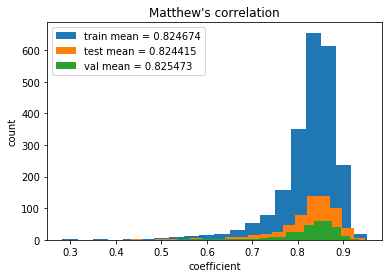

In [49]:
#plot a histogram of the Matthew's correlation coefficients
train_co = train_confusion_df.Matthews_correlation.mean()
test_co = test_confusion_df.Matthews_correlation.mean()
val_co = validate_confusion_df.Matthews_correlation.mean()
_ = plt.hist(train_confusion_df.Matthews_correlation, bins=20)
_ = plt.hist(test_confusion_df.Matthews_correlation, bins=20)
_ = plt.hist(validate_confusion_df.Matthews_correlation, bins=20)
_ = plt.legend(['train mean = %f' % train_co, 'test mean = %f' % test_co, 'val mean = %f' % val_co], loc='upper left')
_ = plt.title('Matthew\'s correlation')
_ = plt.ylabel('count')
_ = plt.xlabel('coefficient')
plt.savefig('/content/drive/My Drive/Colab Notebooks/MCC_mean_all.png')

There is some unexplained heterogenerity in the results. It is clear that the predictions for weekends are better than for the weekdays, based on the pattern of the results (repeating groups of 5). Let's look closer to see what hours are correspoinding with the minimum values for the Matthew's correlation use a cutoff of 0.7 (visually inspected from graphs above). We know what the starting time for each set is as well, so lets convert the index back into the datetime format.

In [0]:
# start date = 12-02-2018. start time is 6:00 am. once finished train, look at last time stamp and increment by 1 for start of test etc

train_confusion_time_df = train_confusion_df.set_index(pd.date_range(start='12-02-2018 6:00', periods=2259, freq='H'))
test_confusion_time_df = test_confusion_df.set_index(pd.date_range(start='2019-03-06 15:00', periods=641, freq='H'))
validate_confusion_time_df = validate_confusion_df.set_index(pd.date_range(start='2019-04-03 14:00', periods=318, freq='H'))

In [51]:
test_confusion_time_df.tail()

,ground_truth,true_positive,false_positive,false_negative,true_negative,Matthews_correlation
2019-04-02 03:00:00,94,51,4,43,3998,0.704560
2019-04-02 04:00:00,133,90,2,43,3961,0.808842
2019-04-02 05:00:00,155,130,1,25,3940,0.909268
2019-04-02 06:00:00,163,145,10,18,3923,0.908707
2019-04-02 07:00:00,165,145,17,20,3914,0.882186


In [52]:
#find the hours with a MCC socre < 0.70 in the test set
train_confusion_sub70 = (train_confusion_time_df[train_confusion_time_df.Matthews_correlation < 0.70]).index
train_confusion_sub70[:20]


DatetimeIndex(['2018-12-04 01:00:00', '2018-12-04 02:00:00',
               '2018-12-05 01:00:00', '2018-12-05 02:00:00',
               '2018-12-05 03:00:00', '2018-12-06 01:00:00',
               '2018-12-07 01:00:00', '2018-12-07 03:00:00',
               '2018-12-10 01:00:00', '2018-12-10 02:00:00',
               '2018-12-11 01:00:00', '2018-12-11 02:00:00',
               '2018-12-11 03:00:00', '2018-12-12 01:00:00',
               '2018-12-12 02:00:00', '2018-12-13 01:00:00',
               '2018-12-14 01:00:00', '2018-12-17 01:00:00',
               '2018-12-18 01:00:00', '2018-12-18 02:00:00'],
              dtype='datetime64[ns]', freq=None)

In [53]:
#find the hours with a MCC socre < 0.70 in the train set
test_confusion_sub70 = (test_confusion_time_df[test_confusion_time_df.Matthews_correlation < 0.70]).index
test_confusion_sub70[:20]


DatetimeIndex(['2019-03-07 01:00:00', '2019-03-07 02:00:00',
               '2019-03-07 03:00:00', '2019-03-08 01:00:00',
               '2019-03-08 02:00:00', '2019-03-08 03:00:00',
               '2019-03-11 01:00:00', '2019-03-12 01:00:00',
               '2019-03-12 02:00:00', '2019-03-12 03:00:00',
               '2019-03-13 00:00:00', '2019-03-13 01:00:00',
               '2019-03-14 01:00:00', '2019-03-14 02:00:00',
               '2019-03-15 01:00:00', '2019-03-18 01:00:00',
               '2019-03-19 01:00:00', '2019-03-19 02:00:00',
               '2019-03-19 03:00:00', '2019-03-20 01:00:00'],
              dtype='datetime64[ns]', freq=None)

In [54]:
#find the hours with a MCC socre < 0.70 in the validate set
validate_confusion_sub70 = (validate_confusion_time_df[validate_confusion_time_df['Matthews_correlation'] < 0.70]).index
validate_confusion_sub70[:20]

DatetimeIndex(['2019-04-04 00:00:00', '2019-04-04 01:00:00',
               '2019-04-04 02:00:00', '2019-04-05 01:00:00',
               '2019-04-06 01:00:00', '2019-04-09 01:00:00',
               '2019-04-09 03:00:00', '2019-04-10 01:00:00',
               '2019-04-11 01:00:00', '2019-04-11 02:00:00',
               '2019-04-12 02:00:00', '2019-04-13 01:00:00',
               '2019-04-13 03:00:00', '2019-04-16 01:00:00',
               '2019-04-16 02:00:00', '2019-04-16 03:00:00'],
              dtype='datetime64[ns]', freq=None)

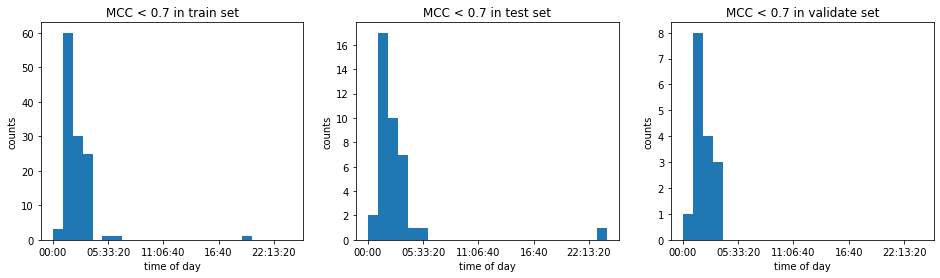

In [55]:
#plot histograms of the hours where the lower MCC values occur
import matplotlib.axis
fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title('MCC < 0.7 in train set')
plt.ylabel('counts')
plt.xlabel('time of day')
_ = plt.hist(train_confusion_sub70.time, bins=24, range=[0,86400])
plt.subplot(1,3,2)
plt.title('MCC < 0.7 in test set')
plt.ylabel('counts')
plt.xlabel('time of day')
_ = plt.hist(test_confusion_sub70.time, bins=24, range=[0,86400])
plt.subplot(1,3,3)
plt.title('MCC < 0.7 in validate set')
plt.ylabel('counts')
plt.xlabel('time of day')
_ = plt.hist(validate_confusion_sub70.time, bins=24,  range=[0,86400])
plt.savefig('/content/drive/My Drive/Colab Notebooks/MCC_time_of_day.png')


Throughout the train, test, validate sets, we see that the lowest Matthew's correlation coefficient is largely seen between the hours of 1 and 3 am. This indicates that our model is less predictive for these hours. What would the MCC score be if we ignored these lower scoring hours?

In [56]:
# negate the indexes above to slice the score dataframes to get mean of the higher MCC regions
trhm = train_confusion_time_df.loc[~train_confusion_time_df.index.isin(train_confusion_sub70)].Matthews_correlation.mean()
tehm = test_confusion_time_df.loc[~test_confusion_time_df.index.isin(test_confusion_sub70)].Matthews_correlation.mean()
vhm = validate_confusion_time_df.loc[~validate_confusion_time_df.index.isin(validate_confusion_sub70)].Matthews_correlation.mean()
print(f'The mean of the MCC values for the higher scoring regions are: \nTrain: {trhm}, Test:{tehm}, Validate: {vhm}')


The mean of the MCC values for the higher scoring regions are: 
Train: 0.8366085534714439, Test:0.8371078480686065, Validate: 0.8361304969493446


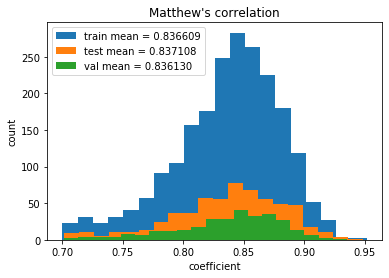

In [57]:
#plot a histogram of the separated Matthew's correlation coefficients
_ = plt.hist(train_confusion_time_df.loc[~train_confusion_time_df.index.isin(train_confusion_sub70)].Matthews_correlation, bins=20)
_ = plt.hist(test_confusion_time_df.loc[~test_confusion_time_df.index.isin(test_confusion_sub70)].Matthews_correlation, bins=20)
_ = plt.hist(validate_confusion_time_df.loc[~validate_confusion_time_df.index.isin(validate_confusion_sub70)].Matthews_correlation, bins=20)
_ = plt.legend(['train mean = %f' % trhm, 'test mean = %f' % tehm, 'val mean = %f' % vhm], loc='upper left')
_ = plt.title('Matthew\'s correlation')
_ = plt.ylabel('count')
_ = plt.xlabel('coefficient')
plt.savefig('/content/drive/My Drive/Colab Notebooks/MCC_mean_refined.png')

Our model can predict even unseen future data with a Matthew's correlation coefficient of 0.84. Not a bad first effort.

End of notebook